## Federal Reserve Sentiment and Macro-Tracking ETFs
By John Loeber

Notebook released under the Creative Commons Attribution 4.0 License.

---

### Abstract

We try to find relationships between macro-tracking ETFs and the sentiment of the Federal Reserve Bank. We conclude that while these relationships seem to exist for certain ETFs, we need to incorporate higher-level macroeconomic variables to use these relationships as signals in practice.

### Introduction

[Prattle](http://prattle.co/) provides sentiment data from central bank communications. We explore their  Central Bank Sentiment Dataset: this dataset contains weekly *sentiment data* from many central banks around the globe (though we focus on the Federal Reserve Bank). The sentiment data wraps up all publications of the Fed from every week (between about 1998 and 2015) into a single real number representing the general sentiment of the Fed that week.

We try to find a relationship between sentiment at the Federal Reserve and various macro-tracking ETFs. We quickly find that the data itself is quite noisy. To mitigate the noise, we use [Kalman-Filtered Moving Averages](https://www.quantopian.com/posts/quantopian-lecture-series-kalman-filters) in our investigation. In this context, a Kalman Filter is a mathematical tool that allows us to construct moving averages that don't have the drawbacks of traditionally calculated moving averages.

We look at the following ETFs (relationship with the Fed Sentiment data included parenthetically):
- SHY (no signal)
- IEI (no signal)
- IEF (possible signal)
- TLT (probably a signal)
- CWB (probably no signal)
- DIA (probably a signal)
- SPY (probably a signal)
- GLD (probably no signal)

### Conclusion

We conclude that finding relationships between Fed Sentiment Data and certain macro-tracking ETFs is possible, and in the cases of DIA and SPY looks quite promising, but can be problematic because of macroeconomic [confounders](https://en.wikipedia.org/wiki/Confounding). It seems that for the ETFs that have a reasonably close correspondence to Fed Sentiment, both Fed Sentiment and those ETFs really respond to the same general macroeconomic variables. However, they respond at different speeds -- so sometimes the Fed Sentiment responds first, at other times the ETF price responds first. Thus, when taking Fed Sentiment data as a signal, it is not easy to know whether you are moving to capture a future trend, or whether you are moving to capture a past trend. This makes it harder to trade on Fed Sentiment, though not at all impossible.

## Investigation

In [48]:
# Import libraries we will use
from matplotlib import pyplot
import datetime
import time
from pykalman import KalmanFilter
import numpy
import scipy
import pandas

In [49]:
# grab the prattle dataset
prattle_data = local_csv('prattle.csv')
# filter to data from the fed only
fed_data = prattle_data[prattle_data.bank=='frc']

In [50]:
# helper functions

def convert_date(mydate):
    return datetime.datetime.strptime(mydate, "%Y-%m-%d")

# for grabbing dates and prices for a relevant equity
def get_data(etf_name,trading_start,trading_end='2015-07-20'):
    # using today as a default arg: assuming most of the ETFs I want to inspect
    # are still trading.
    stock_data = get_pricing(etf_name,
                        start_date = trading_start,
                        end_date = trading_end,
                        fields = ['close_price'],
                        frequency = 'daily')
    stock_data['date'] = stock_data.index

    # drop nans. For whatever reason, nans were causing the kf to return a nan array.
    stock_data = stock_data.dropna()
    # the dates are just those on which the prices were recorded
    dates = stock_data['date']
    dates = [convert_date(str(x)[:10]) for x in dates]
    prices = stock_data['close_price']
    return dates, prices

# for grabbing the prattle data on which the etf has been trading.
def get_prattle(trading_start,trading_end='2015-07-20'):
    # filter down to the relevant time period
    data_prattle = fed_data[fed_data.date > trading_start]
    data_prattle = data_prattle[trading_end > data_prattle.date]
    dates_prattle = data_prattle['date']
    dates_prattle = [convert_date(str(x)[:10]) for x in dates_prattle]
    scores_prattle = data_prattle['score']
    return dates_prattle, scores_prattle

## SHY

The first ETF we will test against the Prattle data is **SHY**. It's a [1-3 Year Treasury Bond ETF](http://etfdb.com/type/bond/treasuries/) that has been trading since `2002-06-24`. It's the most popular Treasury Bond ETF, storing nearly $11bn in assets.

In [51]:
# grab the SHY dataset.
dates_shy, prices_shy = get_data('SHY', '06-24-2002')
# grab the relevant prattle data.
dates_shy_prattle, scores_shy_prattle = get_prattle('2002-06-24')

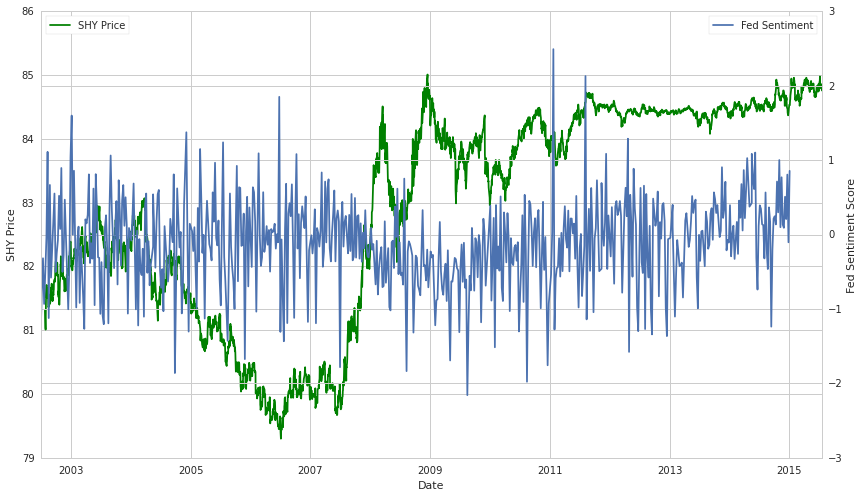

In [52]:
# Lay a sentiment plot over a plot of SHY price

fig, ax1 = pyplot.subplots()
ax1.plot(dates_shy,prices_shy,c='green',label='SHY Price')
pyplot.xlabel('Date')
pyplot.ylabel('SHY Price')
pyplot.legend(loc=2)
# twinx to plot on the same graph
ax2 = ax1.twinx()
ax2.plot(dates_shy_prattle,scores_shy_prattle, label='Fed Sentiment')
pyplot.ylabel('Fed Sentiment Score')
pyplot.legend(loc=1)

pyplot.show()

The above graph is not particularly clear. There's a lot of noise. We'll construct some Kalman-filtered moving averages for both Fed Sentiment Score and SHY Price and overlay them to see if there are any patterns.

We'll also take this opportunity to explain the Fed Sentiment Score: Prattle collects all textual publications from a central bank, and uses natural language processing techniques to assign a sentiment score to each publication -- a positive score means a bullish market outlook, a negative score a bearish one. The further from zero, the more extreme the outlook: the sentiment scores are normally distributed about zero. The weekly sentiment score is effectively the average of all sentiment scores for publications that week.

In [53]:
# Initialize a Kalman Filter.
# Using kf to filter does not change the values of kf, so we don't need to ever reinitialize it.
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

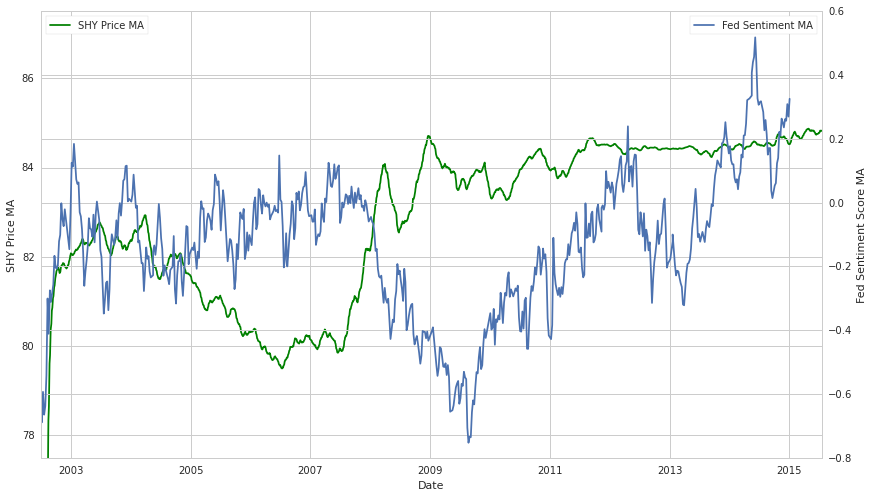

In [54]:
# Filter Rolling Means
prices_shy_means, _ = kf.filter(prices_shy.values)
scores_shy_prattle_means, _ = kf.filter(scores_shy_prattle.values)

# Overlay Plots
fig, ax1 = pyplot.subplots()
ax1.plot(dates_shy,prices_shy_means,c='green',label='SHY Price MA')
pyplot.ylim([77.5,87.5])
pyplot.xlabel('Date')
pyplot.ylabel('SHY Price MA')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_shy_prattle,scores_shy_prattle_means, label='Fed Sentiment MA')
pyplot.ylabel('Fed Sentiment Score MA')
pyplot.legend(loc=1)

pyplot.show()

At first glance, there appears to be a lagged relationship between the two moving averages. If we look at the rise, fall, and rise of the SHY price MA approximately between mid-2004 and mid-2009, we can see a correspondence to the rise, fall, and rise of the Fed Sentiment MA approximately between 2007 and 2012. However, there are two serious caveats to this observation:
1. SHY is what we would potentially be investing in. The fact that this signal precedes the change in Fed Sentiment is not useful -- we would want it to be the other way around, i.e. for the change in Fed Sentiment to precede change in SHY.
2. This may be a spurious correlation: looking at SHY from mid-2011 onwards, there's very little change in the MA. On the other hand, there are massive shifts in Fed Sentiment Score. This suggests that the two variables are not related.

We conclude that the Fed Sentiment Score MA does not provide an effective signal for trading SHY.

## IEI, IEF

Next, we use the same procedure to test the **IEI** ETF against the Prattle data. Similar to SHY, IEI tracks 3-7 year Treasury Bonds. It's also quite popular, storing about $5bn in assets. IEI started trading on 11 Jan 2007.

In [55]:
# grab the IEI dataset and relevant prattle data.
dates_iei, prices_iei = get_data('IEI', '2007-01-11')
dates_iei_prattle, scores_iei_prattle = get_prattle('2007-01-11')

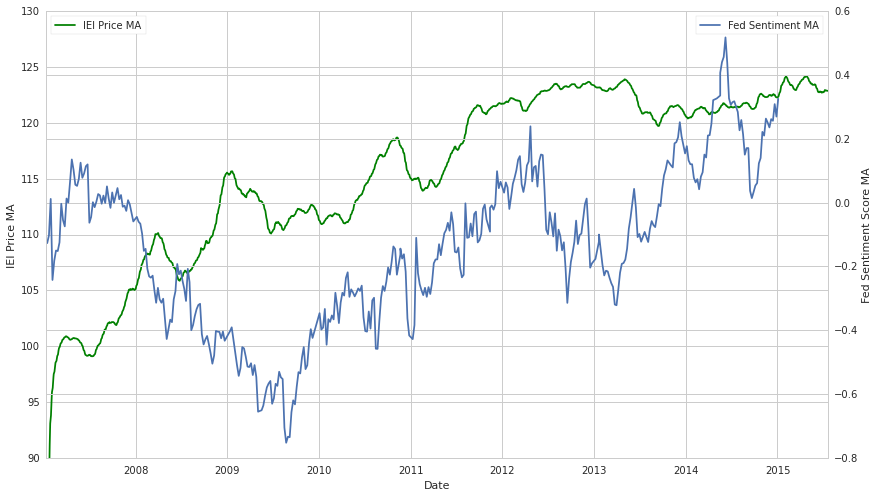

In [56]:
# Filter Rolling Means
prices_iei_means, _ = kf.filter(prices_iei.values)
scores_iei_prattle_means, _ = kf.filter(scores_iei_prattle.values)

# Overlay Plots
fig, ax1 = pyplot.subplots()
ax1.plot(dates_iei,prices_iei_means,c='green',label='IEI Price MA')
pyplot.ylim([90,130])
pyplot.xlabel('Date')
pyplot.ylabel('IEI Price MA')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_iei_prattle,scores_iei_prattle_means, label='Fed Sentiment MA')
pyplot.ylabel('Fed Sentiment Score MA')
pyplot.legend(loc=1)
pyplot.show()

It is visually quite apparent that there most likely isn't a tradeable signal here. There are large trends in Fed Sentiment and IEI Price that do not match each other.

We also looked into **IEF**, which tracks 7-10 year treasury bonds, started trading on `2002-06-24`, and stores about $6bn in assets. With IEF, we got results very similar to those for IEI. In the interest of brevity, we'll thus skip the IEF section.

## TLT

Finally, we look at **TLT**, which tracks 20+ year treasury bonds. TLT stores about $6bn in assets. TLT started trading on `2002-06-24`.

In [59]:
# grab the TLT dataset and relevant prattle data.
dates_tlt, prices_tlt = get_data('TLT', '2002-06-24')
dates_tlt_prattle, scores_tlt_prattle = get_prattle('2002-06-24')

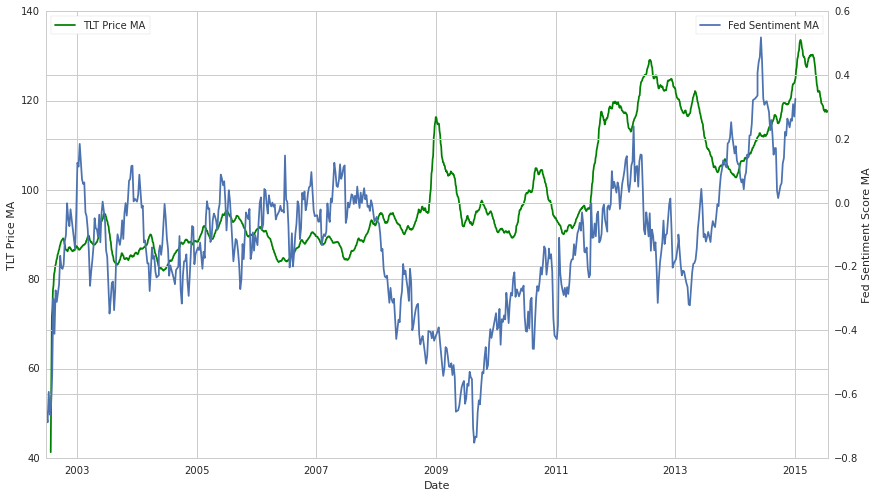

In [60]:
# Filter Rolling Means
prices_tlt_means, _ = kf.filter(prices_tlt.values)
scores_tlt_prattle_means, _ = kf.filter(scores_tlt_prattle.values)

# Overlay Plots
fig, ax1 = pyplot.subplots()
ax1.plot(dates_tlt,prices_tlt_means,c='green',label='TLT Price MA')
pyplot.xlabel('Date')
pyplot.ylabel('TLT Price MA')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_tlt_prattle,scores_tlt_prattle_means, label='Fed Sentiment MA')
pyplot.ylabel('Fed Sentiment Score MA')
pyplot.legend(loc=1)
pyplot.show()

This one is a little more promising: it looks like there is a very rough correspondence between the two time-series, though only if we shift the green one back by a few hundred days. We can think of the green peak at around 2009 to correspond to the less pronounced blue peak around mid-2007. With this shift, the following troughs and rises also correspond. We shift the TLT data back by 300 days to get a better look.

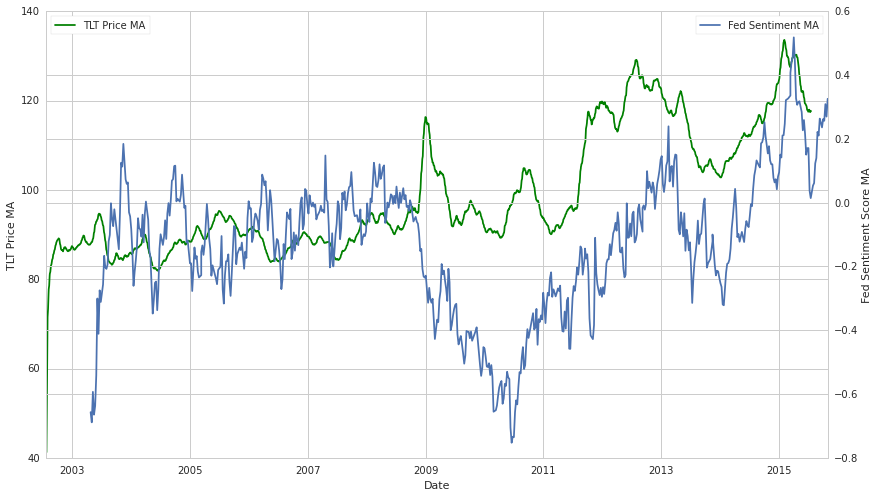

In [61]:
# Overlay Plots
fig, ax1 = pyplot.subplots()
ax1.plot(dates_tlt,prices_tlt_means,c='green',label='TLT Price MA')
pyplot.xlabel('Date')
pyplot.ylabel('TLT Price MA')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
dates_tlt_prattle2 = map(lambda x: x+datetime.timedelta(days=300), dates_tlt_prattle)
ax2.plot(dates_tlt_prattle2,scores_tlt_prattle_means, label='Fed Sentiment MA')
pyplot.ylabel('Fed Sentiment Score MA')
pyplot.legend(loc=1)

pyplot.show()

Having overlaid the time-series, we can see some kind of rough correspondence between the two, given some time-shift. We want to figure out what time shift maximizes the correspondence. We cannot immediately apply a [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation) because the data from the Fed is weekly and the TLT price data is daily. We have to make some adjustments before we can come to any conclusions on TLT -- thus, we postpone this investigation to a later time (i.e. a separate notebook).

That being said, reflecting on IEI, IEF, and TLT, we may find ourselves somewhat surprised that there isn't a stronger relationship between Federal Reserve sentiment and treasury bond ETF price. We would expect that Fed sentiment would have a stronger impact on the shorter-term treasury bond ETFs.

## CWB

Next, we look at **CWB**, which is the Barclays Capital Convertible Securities, which tracks the Barclays U.S. Convertible Bond \$500MM Index. CWB includes bonds with an outstanding issue size of more than \$500m and more than 31 days to maturity. CWB stores about \$3bn in assets. CWB started trading on `2009-04-16`.

In [62]:
# grab the CWB dataset.
dates_cwb, prices_cwb = get_data('CWB', '2009-04-16')
# grab the relevant prattle data.
dates_cwb_prattle, scores_cwb_prattle = get_prattle('2009-04-16')

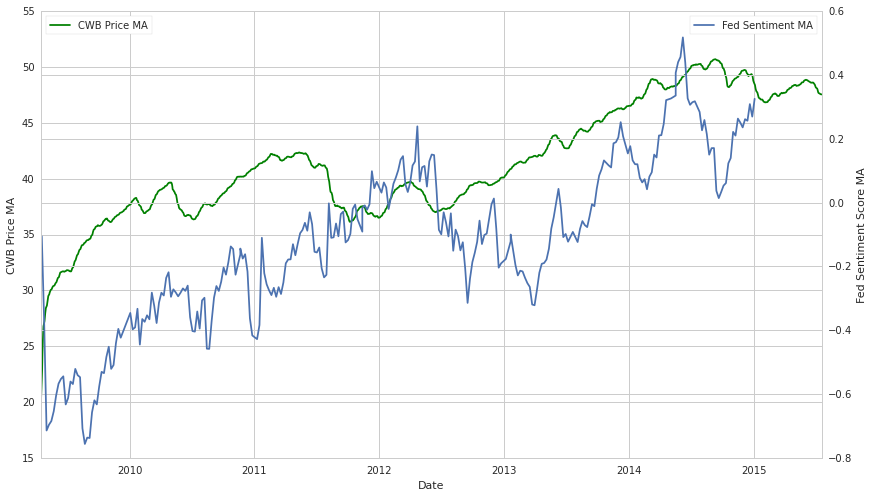

In [63]:
# Filter Rolling Means
prices_cwb_means, _ = kf.filter(prices_cwb.values)
scores_cwb_prattle_means, _ = kf.filter(scores_cwb_prattle.values)

# Overlay Plots
fig, ax1 = pyplot.subplots()
ax1.plot(dates_cwb,prices_cwb_means,c='green',label='CWB Price MA')
pyplot.xlabel('Date')
pyplot.ylabel('CWB Price MA')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_cwb_prattle,scores_cwb_prattle_means, label='Fed Sentiment MA')
pyplot.ylabel('Fed Sentiment Score MA')
pyplot.legend(loc=1)
pyplot.show()

It's not clear whether there is a relationship here -- both moving averages follow a reasonably clear upward trajectory, and there appear to be some corresponding dips and rises. On the other hand, if we propose that the two variables are related, then CWB Price appears to be the causal variable, because wherever in this plot we see CWB and Fed Sentiment moving in some corresponding way, CWB will move first. 

But that's barely plausible: a price change in CWB or TLT is unlikely to change Fed Sentiment, because these ETFs are far too small to be of economic concern. We'll discuss this in more detail in the next section.

## DIA

Next, we look at **DIA**, which tracks the Dow Jones Industrial Average. DIA stores about \$11bn in assets. DIA started trading on `1998-01-20`. Since we have data only from 2002 onwards, we'll start our investigation at `2002-03-03`.

In [64]:
# grab the DIA dataset and relevant prattle data.
dates_dia, prices_dia = get_data('DIA', '2002-03-03')
dates_dia_prattle, scores_dia_prattle = get_prattle('2002-03-03')

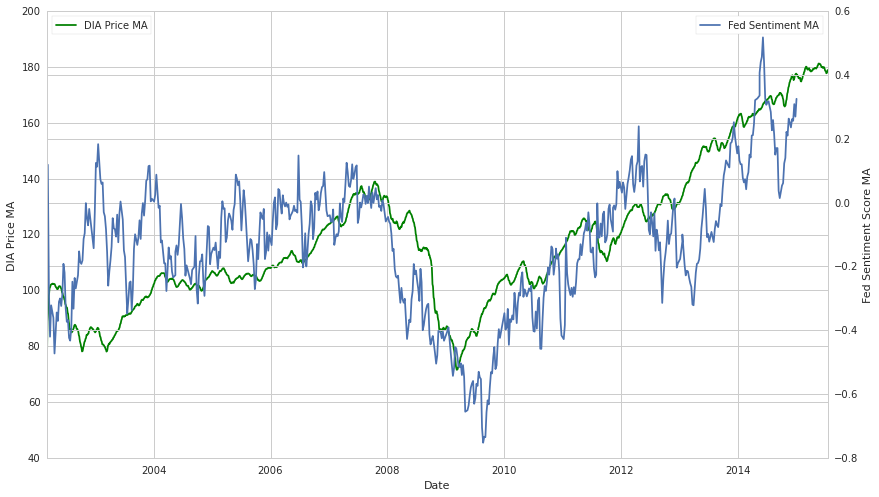

In [65]:
# Filter Rolling Means
prices_dia_means, _ = kf.filter(prices_dia.values)
scores_dia_prattle_means, _ = kf.filter(scores_dia_prattle.values)

# Overlay Plots
fig, ax1 = pyplot.subplots()
ax1.plot(dates_dia,prices_dia_means,c='green',label='DIA Price MA')
pyplot.xlabel('Date')
pyplot.ylabel('DIA Price MA')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_dia_prattle,scores_dia_prattle_means, label='Fed Sentiment MA')
pyplot.ylabel('Fed Sentiment Score MA')
pyplot.legend(loc=1)
pyplot.show()

This looks as if there could be a strong trading signal. (This potential signal warrants deeper investigation, which exceeds the scope of this notebook.) Note that certain shifts in Fed Sentiment Data precede the shifts in DIA Price, whereas in other cases the shift in Fed Sentiment Data is preceded by a shift in DIA price.

What's troublesome with that -- and we pointed it out in the previous section on CWB -- is that the causal relationship is not clear. It's unclear which one of the two variables is acting and which is reacting. We remarked that it is implausible for a single ETF to influence Fed Sentiment, but we also know that it is possible for the ETF price change to be due to some other variable that *does* impact Fed Sentiment.

In other words, the solution to the problem is that **there's some hidden macroeconomic [confounder](https://en.wikipedia.org/wiki/Confounding)**. The confounder explains why we sometimes see the ETF move first, and at other times see the Fed sentiment move first: there's some general macroeconomic variable (or, more likely, several of them) to which macro-tracking ETFs and Fed Sentiment respond with different speeds.

An illustration of the confounding variable below:

<img align="left" src="http://s7.postimg.org/xaxic2k57/fed1.png">

This explains situations in which the ETF price moves first, followed by Fed sentiment, and it may also explain situations in which Fed sentiment moves first and ETF price follows. However, there is also the possibility of Fed sentiment moving first and, by itself, impacting ETF price. In those situations, it may be hard to measure the extent to which Fed sentiment impacted ETF price, and the extent to which some overarching variable impacted ETF price.

## SPY

Similar to DIA, we now look at **SPY**, which tracks the Standard & Poor's 500 Index. At the time of writing, SPY has a market cap of about \$177bn. SPY started trading on `1993-01-29`. Since we have data only from 2002 onwards, we'll start our investigation at `2002-03-03`.

In [66]:
# grab the SPY dataset and relevant prattle data.
dates_spy, prices_spy = get_data('SPY', '2002-03-03')
dates_spy_prattle, scores_spy_prattle = get_prattle('2002-03-03')

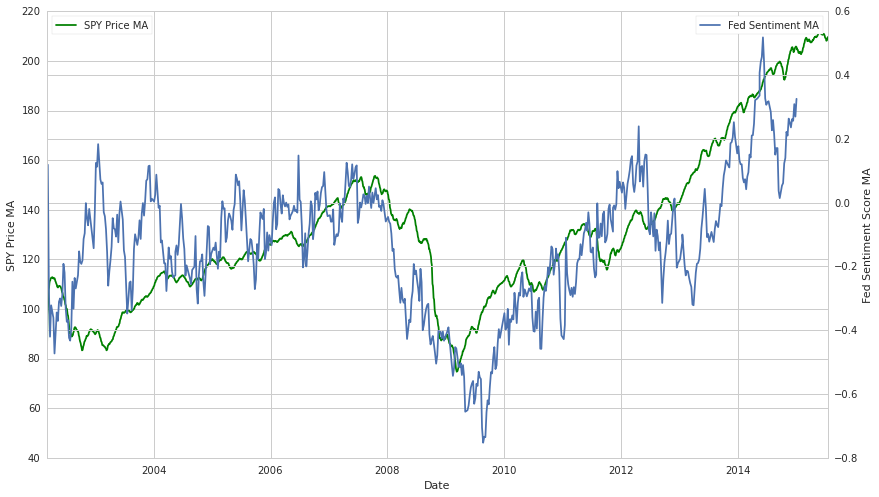

In [67]:
# Filter Rolling Means
prices_spy_means, _ = kf.filter(prices_spy.values)
scores_spy_prattle_means, _ = kf.filter(scores_spy_prattle.values)

# Overlay Plots
fig, ax1 = pyplot.subplots()
ax1.plot(dates_spy,prices_spy_means,c='green',label='SPY Price MA')
pyplot.xlabel('Date')
pyplot.ylabel('SPY Price MA')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_spy_prattle,scores_spy_prattle_means, label='Fed Sentiment MA')
pyplot.ylabel('Fed Sentiment Score MA')
pyplot.legend(loc=1)
pyplot.show()

We know (as a prior) that SPY and DIA are quite strongly correlated, and since we know from above that Fed Sentiment and DIA have a strong correspondence, we could expect SPY and Fed Sentiment to correspond quite strongly as well, which, as we can see, is the case. This result is unsurprising, but interesting for the same reasons that the previous result was interesting.

We note the **near-monotonic increase in SPY price since about 2010, reflecting the exceptional bull market during this period**. It is remarkable that SPY has risen in this fashion despite serious swings in Fed Sentiment. The take-away lesson from that is not clear.

## GLD

Finally, we look at **GLD**, which is the largest gold ETF, storing assets of about \$24bn. GLD started trading on `2004-11-18`. We expect GLD to slowly appreciate in value (beating inflation), but to swing up especially in times of bad sentiment, as the price of gold usually shoots up when there is macroeconomic-level fear.

In [68]:
# grab the GLD dataset and relevant prattle data.
dates_gld, prices_gld = get_data('GLD', '2004-11-18')
dates_gld_prattle, scores_gld_prattle = get_prattle('2004-11-18')

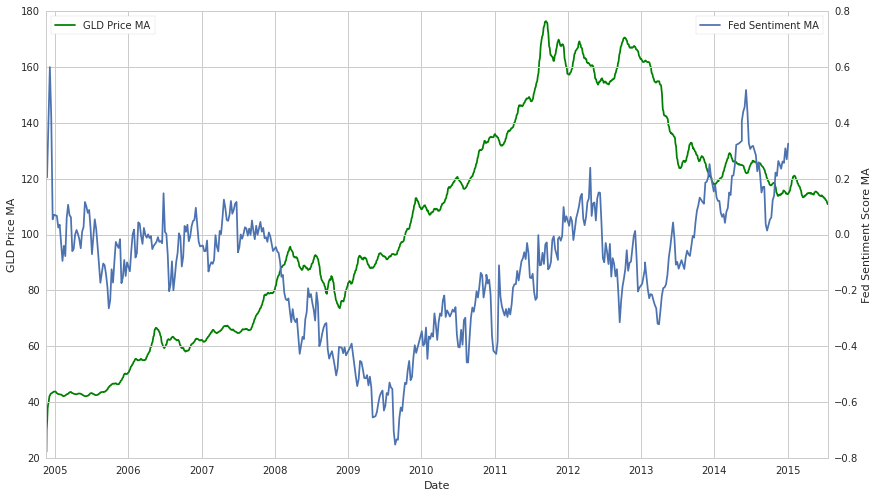

In [69]:
# Filter Rolling Means
prices_gld_means, _ = kf.filter(prices_gld.values)
scores_gld_prattle_means, _ = kf.filter(scores_gld_prattle.values)

# Overlay Plots
fig, ax1 = pyplot.subplots()
ax1.plot(dates_gld,prices_gld_means,c='green',label='GLD Price MA')
pyplot.xlabel('Date')
pyplot.ylabel('GLD Price MA')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_gld_prattle,scores_gld_prattle_means, label='Fed Sentiment MA')
pyplot.ylabel('Fed Sentiment Score MA')
pyplot.legend(loc=1)

pyplot.show()

Fascinating! There are sections of seemingly-proportional movement, and other sections of seemingly inversely-proportional movement. In these movements, we also see the Fed Sentiment going first, then followed by gold (e.g. between 2008 and 2009, or mid-2012 and 2014), but on other occasions, we see gold moving first, then followed by Fed Sentiment (e.g. between 2009 and mid-2010). 

This hearkens back to the evaluation of CWB -- there's a macroeconomic confounder at work. For that reason, and because of the seemingly shifting proportionality in relationship, **attempting to use Fed Sentiment as a predictor of Gold Price is likely a risky endeavour**. That being said, it may be possible to constrain trading to a particular set of circumstances in which Gold Price follows Fed Sentiment. 

We note that the interesting relationship between GLD and Fed Sentiment might be explained by the fact that Gold is heavily traded internationally -- it is well possible that the price shifts in GLD that seem counter-intuitve are in fact explained by international macro activity. 

Again, further investigation is warranted.

### Summary of Opportunities for Further Investigation

We came across a few topics that warrant further investigation. Perhaps I will address these in future notebooks, but they are also good research projects for you to get involved with:
 - Cross-correlate TLT and Fed Sentiment and assess the strength of that relationship
 - Cross-correlate DIA/SPY and Fed Sentiment, assess the strength of those relationships
 - Try to find the confounding variables in the relationship between DIA and Fed Sentiment
 - Look into GLD and international central bank data -- the gold price is dictated by international trade, so we must consider international macroeconomic activity when trying to predict it.

### More About Prattle

> From the smallest companies to the largest banks, the market is always talking. Prattle decodes this chatter, producing quantitative, real-time, tradable signals from noise. Prattle’s core product, the Fed Index, is created using language processing programs in concert with domain expertise to comprehensively and quantitatively evaluate the economic impact of the central bank’s language. Along with the Federal Reserve, Prattle evaluates 18 central banks overseeing over 90 percent of global GDP, providing financial professionals with actionable, easily integratable data on the market’s biggest movers.

Please reach out to info@prattle.co if you have any questions or want access to their data.